# Multi-Subject HR Analysis Dashboard

## SCAI-NCGG Dataset Inspection and Comparative Analysis

This notebook processes and inspects data from multiple participants through the HR metrics pipeline.

## 1. Import Required Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import glob
from collections import defaultdict

warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

Libraries imported successfully


## 2. Define File Paths and Subject IDs

In [9]:
# Define base directory and subjects
DATA_BASE = Path(r'D:\ETHZ\Lifelogging\interim\scai-ncgg')

SUBJECTS = [
    'sim_elderly_1', 'sim_elderly_2',
    'sim_healthy_1', 'sim_healthy_2',
    'sim_severe_1', 'sim_severe_2',
    'sub_0103', 'sub_0301', 'sub_0301_2', 'sub_0302', 'sub_0303', 'sub_0304', 'sub_0305'
]

# Batch output directory (most recent) - Updated after batch run
BATCH_DIR = Path('./output_batch/batch_20260206_172823')

# All batch directories for comparison
BATCH_OUTPUT_BASE = Path('./output_batch')

def get_most_recent_batch_dir() -> Path:
    """Get the most recent batch directory"""
    if BATCH_OUTPUT_BASE.exists():
        batch_dirs = sorted(BATCH_OUTPUT_BASE.glob('batch_*'), reverse=True)
        if batch_dirs:
            return batch_dirs[0]
    return BATCH_DIR

# Test paths
print(f"Data base: {DATA_BASE}")
print(f"Current batch dir: {get_most_recent_batch_dir()}")
print(f"Batch dir exists: {get_most_recent_batch_dir().exists()}")
print(f"Number of subjects: {len(SUBJECTS)}")
print(f"\nBatch contents:")
if get_most_recent_batch_dir().exists():
    for item in get_most_recent_batch_dir().iterdir():
        if item.is_dir():
            print(f"  {item.name}/")


Data base: D:\ETHZ\Lifelogging\interim\scai-ncgg
Current batch dir: output_batch\batch_20260206_172823
Batch dir exists: True
Number of subjects: 13

Batch contents:
  sim_elderly_1/
  sim_elderly_2/
  sim_elderly_3/
  sim_elderly_4/
  sim_elderly_5/
  sim_healthy_1/
  sim_healthy_2/
  sim_healthy_3/
  sim_healthy_4/
  sim_healthy_5/
  sim_severe_1/
  sim_severe_2/
  sim_severe_3/
  sim_severe_4/
  sim_severe_5/
  sub_0103/
  sub_0301/
  sub_0301_2/
  sub_0302/
  sub_0303/
  sub_0304/
  sub_0305/


## 3. Load Batch Processing Results

In [10]:
# Load batch results summary
batch_results = None
subject_outputs = {}

batch_output_base = Path('./output_batch')

# Get most recent batch directory
batch_dirs = sorted(batch_output_base.glob('batch_*'), reverse=True)

if batch_dirs:
    latest_batch = batch_dirs[0]
    summary_file = latest_batch / 'batch_summary.csv'
    
    if summary_file.exists():
        batch_results = pd.read_csv(summary_file)
        print(f"✓ Loaded batch summary: {summary_file}")
        print(f"  Processed subjects: {len(batch_results)}")
        print(f"\nStatus breakdown:")
        print(batch_results['status'].value_counts())
    
    # Load individual subject outputs
    for subject in SUBJECTS:
        subject_dir = latest_batch / subject
        if subject_dir.exists():
            subject_outputs[subject] = {
                'path': subject_dir,
                'propulsion_file': subject_dir / 'propulsion_hr_metrics.csv',
                'resting_file': subject_dir / 'resting_hr_metrics.csv',
                'washing_file': subject_dir / 'activity_washing_hands_hr_metrics.csv',
                'comparisons_file': subject_dir / 'baseline_activity_comparisons.csv'
            }

if batch_results is None or batch_results.empty:
    print("⚠ No batch results found. Create results by running batch_process_subjects.py")
else:
    print(f"\n✓ Found results for {len(subject_outputs)} subjects")

print(f"\nBatch results shape: {batch_results.shape if isinstance(batch_results, pd.DataFrame) else 'No data'}")

✓ Loaded batch summary: output_batch\batch_20260206_172823\batch_summary.csv
  Processed subjects: 22

Status breakdown:
status
SUCCESS    22
Name: count, dtype: int64

✓ Found results for 13 subjects

Batch results shape: (22, 8)


## 4. Load Individual Subject HR Metrics

In [11]:
# Load HR metrics for all subjects
all_propulsion_metrics = []
all_resting_metrics = []
all_washing_metrics = []
all_comparisons = []

for subject in SUBJECTS:
    if subject not in subject_outputs:
        continue
    
    output_info = subject_outputs[subject]
    
    # Load propulsion metrics
    if output_info['propulsion_file'].exists():
        try:
            df = pd.read_csv(output_info['propulsion_file'])
            if not df.empty:
                df['subject_id'] = subject
                all_propulsion_metrics.append(df)
        except pd.errors.EmptyDataError:
            pass  # Skip empty files
    
    # Load resting metrics
    if output_info['resting_file'].exists():
        try:
            df = pd.read_csv(output_info['resting_file'])
            if not df.empty:
                df['subject_id'] = subject
                all_resting_metrics.append(df)
        except pd.errors.EmptyDataError:
            pass  # Skip empty files
    
    # Load washing hands metrics
    if output_info['washing_file'].exists():
        try:
            df = pd.read_csv(output_info['washing_file'])
            if not df.empty:
                df['subject_id'] = subject
                all_washing_metrics.append(df)
        except pd.errors.EmptyDataError:
            pass  # Skip empty files
    
    # Load comparisons
    if output_info['comparisons_file'].exists():
        try:
            df = pd.read_csv(output_info['comparisons_file'])
            if not df.empty:
                df['subject_id'] = subject
                all_comparisons.append(df)
        except pd.errors.EmptyDataError:
            pass  # Skip empty files

# Combine into DataFrames
propulsion_df = pd.concat(all_propulsion_metrics, ignore_index=True) if all_propulsion_metrics else pd.DataFrame()
resting_df = pd.concat(all_resting_metrics, ignore_index=True) if all_resting_metrics else pd.DataFrame()
washing_df = pd.concat(all_washing_metrics, ignore_index=True) if all_washing_metrics else pd.DataFrame()
comparisons_df = pd.concat(all_comparisons, ignore_index=True) if all_comparisons else pd.DataFrame()

print(f"✓ Loaded HR metrics:")
print(f"  Propulsion activities: {len(propulsion_df)}")
print(f"  Resting activities: {len(resting_df)}")
print(f"  Washing hands activities: {len(washing_df)}")
print(f"  Baseline comparisons: {len(comparisons_df)}")

if len(propulsion_df) > 0:
    print(f"\n✓ Propulsion metrics summary:")
    print(propulsion_df[['subject_id', 'mean_hr', 'rmssd', 'stress_index']].groupby('subject_id').agg(['mean', 'count']).round(2))

if len(resting_df) > 0:
    print(f"\n✓ Resting metrics summary:")
    print(resting_df[['subject_id', 'mean_hr', 'rmssd', 'stress_index']].groupby('subject_id').agg(['mean', 'count']).round(2))

if len(washing_df) > 0:
    print(f"\n✓ Washing hands metrics summary:")
    print(washing_df[['subject_id', 'mean_hr', 'rmssd', 'stress_index']].groupby('subject_id').agg(['mean', 'count']).round(2))

✓ Loaded HR metrics:
  Propulsion activities: 14
  Resting activities: 12
  Washing hands activities: 10
  Baseline comparisons: 10

✓ Propulsion metrics summary:
              mean_hr          rmssd       stress_index      
                 mean count     mean count         mean count
subject_id                                                   
sim_elderly_1   54.17     1  7222.43     1          NaN     0
sim_elderly_2  104.01     1   361.46     1        41.66     1
sim_healthy_1   66.52     1   471.65     1        23.66     1
sim_healthy_2   94.81     1    35.29     1          NaN     0
sim_severe_1    61.96     1   713.95     1        21.07     1
sim_severe_2   100.62     1   354.75     1        51.36     1
sub_0103       107.95     1   361.97     1        11.66     1
sub_0301_2        NaN     0      NaN     0          NaN     0
sub_0302        95.40     1   764.96     1        11.76     1
sub_0303       128.68     2   339.89     2         9.61     1
sub_0305       100.46     3   1

## 5. Inspect Data Quality and Coverage

In [12]:
# Create data quality report
print("=" * 80)
print("DATA COVERAGE AND QUALITY REPORT")
print("=" * 80)

# Data availability
print("\nData Availability:")
print("-" * 80)
data_coverage = []
for subject in SUBJECTS:
    subject_path = DATA_BASE / subject
    has_ecg = (subject_path / 'vivalnk_vv330_ecg' / 'data_1.csv.gz').exists() or \
              list((subject_path / 'vivalnk_vv330_ecg').glob('*/*.csv.gz'))
    has_adl = (subject_path / 'scai_app' / 'ADLs_1.csv.gz').exists() or \
              (subject_path / 'manual_log' / 'ADLs_1.csv.gz').exists()
    
    in_batch = subject in subject_outputs
    
    data_coverage.append({
        'subject_id': subject,
        'ecg_available': '✓' if has_ecg else '✗',
        'adl_available': '✓' if has_adl else '✗',
        'in_batch_results': '✓' if in_batch else '✗',
        'subject_type': 'simulated' if subject.startswith('sim_') else 'real'
    })

coverage_df = pd.DataFrame(data_coverage)
print(coverage_df.to_string(index=False))

print("\n\nSummary:")
print(f"  Total subjects: {len(SUBJECTS)}")
print(f"  Simulated subjects: {(coverage_df['subject_type'] == 'simulated').sum()}")
print(f"  Real subjects: {(coverage_df['subject_type'] == 'real').sum()}")
print(f"  In batch results: {(coverage_df['in_batch_results'] == '✓').sum()}")

# Activity summary
print("\n\nBatch Processing Results:")
print("-" * 80)
if len(batch_results) > 0:
    batch_display = batch_results[['subject_id', 'status', 'subject_type', 
                                           'propulsion_count', 'resting_count']].copy()
    print(batch_display.to_string(index=False))

print(f"\n  Successful: {(batch_results['status'] == 'SUCCESS').sum()}/{len(batch_results)}")
print(f"  Failed: {(batch_results['status'] != 'SUCCESS').sum()}/{len(batch_results)}")

# HR metrics summary by subject type
print("\n\nHR Metrics Summary by Subject Type:")
print("-" * 80)

if len(propulsion_df) > 0:
    # Add subject type
    propulsion_df['subject_type'] = propulsion_df['subject_id'].apply(
        lambda x: 'simulated' if x.startswith('sim_') else 'real'
    )
    
    summary = propulsion_df.groupby('subject_type')[['mean_hr', 'rmssd', 'stress_index']].agg(['mean', 'std', 'count']).round(2)
    print("\nPropulsion Activities:")
    print(summary)

if len(resting_df) > 0:
    # Add subject type
    resting_df['subject_type'] = resting_df['subject_id'].apply(
        lambda x: 'simulated' if x.startswith('sim_') else 'real'
    )
    
    summary = resting_df.groupby('subject_type')[['mean_hr', 'rmssd', 'stress_index']].agg(['mean', 'std', 'count']).round(2)
    print("\nResting Activities:")
    print(summary)


DATA COVERAGE AND QUALITY REPORT

Data Availability:
--------------------------------------------------------------------------------
   subject_id ecg_available adl_available in_batch_results subject_type
sim_elderly_1             ✓             ✓                ✓    simulated
sim_elderly_2             ✓             ✓                ✓    simulated
sim_healthy_1             ✓             ✓                ✓    simulated
sim_healthy_2             ✓             ✓                ✓    simulated
 sim_severe_1             ✓             ✓                ✓    simulated
 sim_severe_2             ✓             ✓                ✓    simulated
     sub_0103             ✓             ✓                ✓         real
     sub_0301             ✓             ✓                ✓         real
   sub_0301_2             ✓             ✓                ✓         real
     sub_0302             ✓             ✓                ✓         real
     sub_0303             ✓             ✓                ✓         real
  

## 6. Visualize and Compare Participant Data

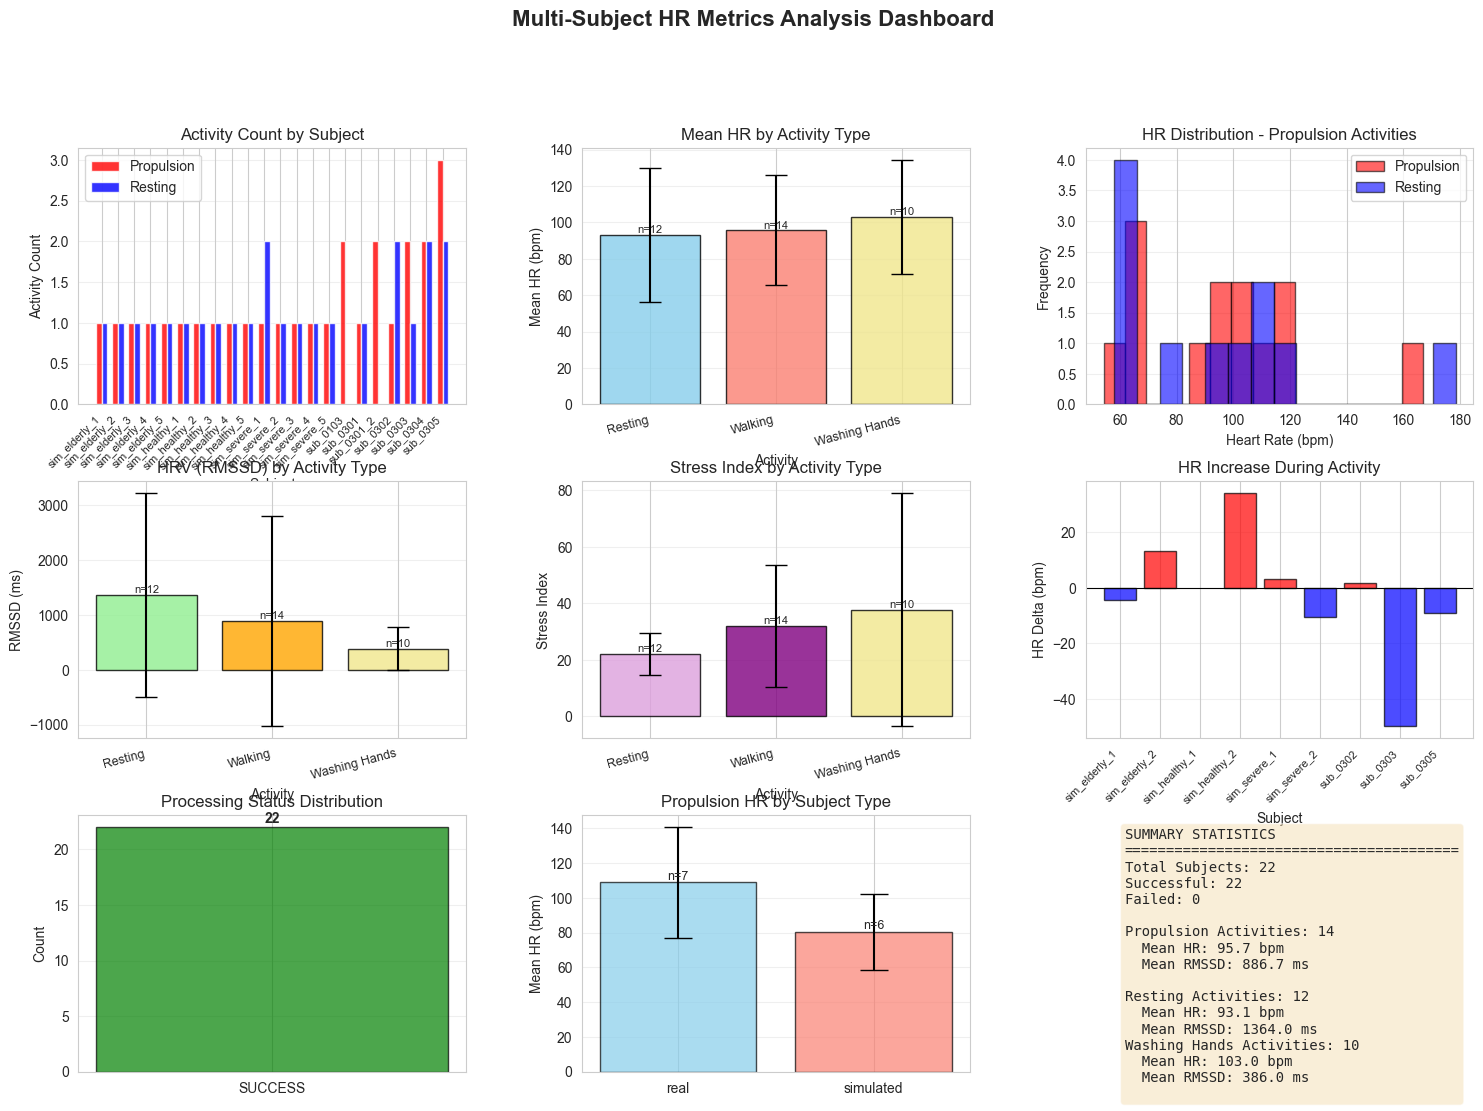


✓ Dashboard visualization saved: output_batch/multi_subject_dashboard.png


In [13]:
# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Activity Count by Subject
ax1 = fig.add_subplot(gs[0, 0])
if len(batch_results) > 0:
    successful = batch_results[batch_results['status'] == 'SUCCESS'].copy()
    if len(successful) > 0:
        x = np.arange(len(successful))
        width = 0.35
        
        prop_counts = successful['propulsion_count'].values
        rest_counts = successful['resting_count'].values
        
        ax1.bar(x - width/2, prop_counts, width, label='Propulsion', alpha=0.8, color='red')
        ax1.bar(x + width/2, rest_counts, width, label='Resting', alpha=0.8, color='blue')
        
        ax1.set_xlabel('Subject')
        ax1.set_ylabel('Activity Count')
        ax1.set_title('Activity Count by Subject')
        ax1.set_xticks(x)
        ax1.set_xticklabels(successful['subject_id'].values, rotation=45, ha='right', fontsize=8)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')

# Helper for activity-level summaries
def _activity_stats(df, label, metric):
    if df is None or len(df) == 0 or metric not in df.columns:
        return None
    return {
        'activity': label,
        'mean': df[metric].mean(),
        'std': df[metric].std(),
        'count': len(df)
    }

# 2. Mean HR Comparison (by activity type)
ax2 = fig.add_subplot(gs[0, 1])
hr_stats = []
for df, label in [(resting_df, 'Resting'), (propulsion_df, 'Walking'), (washing_df, 'Washing Hands')] :
    stat = _activity_stats(df, label, 'mean_hr')
    if stat:
        hr_stats.append(stat)

if hr_stats:
    hr_df = pd.DataFrame(hr_stats)
    x = np.arange(len(hr_df))
    bars = ax2.bar(x, hr_df['mean'].values, yerr=hr_df['std'].values, capsize=8,
                   color=['skyblue', 'salmon', 'khaki'][:len(hr_df)], alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Activity')
    ax2.set_ylabel('Mean HR (bpm)')
    ax2.set_title('Mean HR by Activity Type')
    ax2.set_xticks(x)
    ax2.set_xticklabels(hr_df['activity'].values, rotation=15, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    for i, (bar, count) in enumerate(zip(bars, hr_df['count'].values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'n={int(count)}',
                ha='center', va='bottom', fontsize=8)

# 3. HR Distribution
ax3 = fig.add_subplot(gs[0, 2])
if len(propulsion_df) > 0:
    ax3.hist(propulsion_df['mean_hr'], bins=15, alpha=0.6, label='Propulsion', color='red', edgecolor='black')
    ax3.set_xlabel('Heart Rate (bpm)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('HR Distribution - Propulsion Activities')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

if len(resting_df) > 0:
    ax3.hist(resting_df['mean_hr'], bins=15, alpha=0.6, label='Resting', color='blue', edgecolor='black')
    ax3.legend()

# 4. RMSSD Comparison (by activity type)
ax4 = fig.add_subplot(gs[1, 0])
rmssd_stats = []
for df, label in [(resting_df, 'Resting'), (propulsion_df, 'Walking'), (washing_df, 'Washing Hands')] :
    stat = _activity_stats(df, label, 'rmssd')
    if stat:
        rmssd_stats.append(stat)

if rmssd_stats:
    rmssd_df = pd.DataFrame(rmssd_stats)
    x = np.arange(len(rmssd_df))
    bars = ax4.bar(x, rmssd_df['mean'].values, yerr=rmssd_df['std'].values, capsize=8,
                   color=['lightgreen', 'orange', 'khaki'][:len(rmssd_df)], alpha=0.8, edgecolor='black')
    ax4.set_xlabel('Activity')
    ax4.set_ylabel('RMSSD (ms)')
    ax4.set_title('HRV (RMSSD) by Activity Type')
    ax4.set_xticks(x)
    ax4.set_xticklabels(rmssd_df['activity'].values, rotation=15, ha='right', fontsize=9)
    ax4.grid(True, alpha=0.3, axis='y')
    for i, (bar, count) in enumerate(zip(bars, rmssd_df['count'].values)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height, f'n={int(count)}',
                ha='center', va='bottom', fontsize=8)

# 5. Stress Index Comparison (by activity type)
ax5 = fig.add_subplot(gs[1, 1])
stress_stats = []
for df, label in [(resting_df, 'Resting'), (propulsion_df, 'Walking'), (washing_df, 'Washing Hands')] :
    stat = _activity_stats(df, label, 'stress_index')
    if stat:
        stress_stats.append(stat)

if stress_stats:
    stress_df = pd.DataFrame(stress_stats)
    x = np.arange(len(stress_df))
    bars = ax5.bar(x, stress_df['mean'].values, yerr=stress_df['std'].values, capsize=8,
                   color=['plum', 'purple', 'khaki'][:len(stress_df)], alpha=0.8, edgecolor='black')
    ax5.set_xlabel('Activity')
    ax5.set_ylabel('Stress Index')
    ax5.set_title('Stress Index by Activity Type')
    ax5.set_xticks(x)
    ax5.set_xticklabels(stress_df['activity'].values, rotation=15, ha='right', fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    for i, (bar, count) in enumerate(zip(bars, stress_df['count'].values)):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height, f'n={int(count)}',
                ha='center', va='bottom', fontsize=8)

# 6. HR Delta (Propulsion - Resting)
ax6 = fig.add_subplot(gs[1, 2])
if len(propulsion_df) > 0 and len(resting_df) > 0:
    prop_hr_subj = propulsion_df.groupby('subject_id')['mean_hr'].mean()
    rest_hr_subj = resting_df.groupby('subject_id')['mean_hr'].mean()
    
    common_subjects = prop_hr_subj.index.intersection(rest_hr_subj.index)
    hr_delta = prop_hr_subj[common_subjects] - rest_hr_subj[common_subjects]
    
    colors = ['red' if x > 0 else 'blue' for x in hr_delta.values]
    ax6.bar(range(len(hr_delta)), hr_delta.values, color=colors, alpha=0.7, edgecolor='black')
    
    ax6.set_xlabel('Subject')
    ax6.set_ylabel('HR Delta (bpm)')
    ax6.set_title('HR Increase During Activity')
    ax6.set_xticks(range(len(hr_delta)))
    ax6.set_xticklabels(hr_delta.index, rotation=45, ha='right', fontsize=8)
    ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax6.grid(True, alpha=0.3, axis='y')

# 7. Processing Status
ax7 = fig.add_subplot(gs[2, 0])
if len(batch_results) > 0:
    status_counts = batch_results['status'].value_counts()
    colors_status = {'SUCCESS': 'green', 'FAILED': 'red', 'SKIPPED': 'orange', 'TIMEOUT': 'brown', 'ERROR': 'darkred'}
    colors = [colors_status.get(s, 'gray') for s in status_counts.index]
    
    ax7.bar(status_counts.index, status_counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax7.set_ylabel('Count')
    ax7.set_title('Processing Status Distribution')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(status_counts.values):
        ax7.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

# 8. Subject Type Comparison (Simulated vs Real)
ax8 = fig.add_subplot(gs[2, 1])
if len(propulsion_df) > 0:
    prop_by_type = propulsion_df.groupby('subject_type')['mean_hr'].agg(['mean', 'std', 'count'])
    
    types = prop_by_type.index.tolist()
    means = prop_by_type['mean'].values
    stds = prop_by_type['std'].values
    
    bars = ax8.bar(types, means, yerr=stds, capsize=10, color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
    
    ax8.set_ylabel('Mean HR (bpm)')
    ax8.set_title('Propulsion HR by Subject Type')
    ax8.grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, prop_by_type['count'].values)):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# 9. Data Summary Table
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary_text = "SUMMARY STATISTICS\n" + "=" * 40 + "\n"
if len(batch_results) > 0:
    summary_text += f"Total Subjects: {len(batch_results)}\n"
    summary_text += f"Successful: {(batch_results['status'] == 'SUCCESS').sum()}\n"
    summary_text += f"Failed: {(batch_results['status'] == 'FAILED').sum()}\n\n"

if len(propulsion_df) > 0:
    summary_text += f"Propulsion Activities: {len(propulsion_df)}\n"
    summary_text += f"  Mean HR: {propulsion_df['mean_hr'].mean():.1f} bpm\n"
    summary_text += f"  Mean RMSSD: {propulsion_df['rmssd'].mean():.1f} ms\n\n"

if len(resting_df) > 0:
    summary_text += f"Resting Activities: {len(resting_df)}\n"
    summary_text += f"  Mean HR: {resting_df['mean_hr'].mean():.1f} bpm\n"
    summary_text += f"  Mean RMSSD: {resting_df['rmssd'].mean():.1f} ms\n"

if len(washing_df) > 0:
    summary_text += f"Washing Hands Activities: {len(washing_df)}\n"
    summary_text += f"  Mean HR: {washing_df['mean_hr'].mean():.1f} bpm\n"
    summary_text += f"  Mean RMSSD: {washing_df['rmssd'].mean():.1f} ms\n"

ax9.text(0.1, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Multi-Subject HR Metrics Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('./output_batch/multi_subject_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Dashboard visualization saved: output_batch/multi_subject_dashboard.png")

## 7. Export Comparative Analysis Report

In [14]:
# Create comprehensive comparison report
report_lines = []

report_lines.append("=" * 80)
report_lines.append("MULTI-SUBJECT COMPARATIVE ANALYSIS REPORT")
report_lines.append("=" * 80)
report_lines.append("")

# 1. Overview
report_lines.append("1. DATASET OVERVIEW")
report_lines.append("-" * 80)
if len(batch_results) > 0:
    report_lines.append(f"Total subjects processed: {len(batch_results)}")
    report_lines.append(f"Successful: {(batch_results['status'] == 'SUCCESS').sum()}")
    report_lines.append(f"Failed: {(batch_results['status'] != 'SUCCESS').sum()}")
    report_lines.append(f"Success rate: {(batch_results['status'] == 'SUCCESS').sum() / len(batch_results) * 100:.1f}%")
    report_lines.append("")

# 2. Activity Summary
report_lines.append("2. ACTIVITY SUMMARY")
report_lines.append("-" * 80)
if len(batch_results) > 0:
    successful = batch_results[batch_results['status'] == 'SUCCESS']
    report_lines.append(f"Total propulsion activities: {successful['propulsion_count'].sum()}")
    report_lines.append(f"Total resting activities: {successful['resting_count'].sum()}")
    report_lines.append("")

# 3. HR Metrics by Activity Type
report_lines.append("3. HR METRICS BY ACTIVITY TYPE")
report_lines.append("-" * 80)

if len(propulsion_df) > 0:
    report_lines.append("Propulsion Activities:")
    report_lines.append(f"  Count: {len(propulsion_df)}")
    report_lines.append(f"  Mean HR: {propulsion_df['mean_hr'].mean():.1f} ± {propulsion_df['mean_hr'].std():.1f} bpm")
    report_lines.append(f"  HR range: {propulsion_df['mean_hr'].min():.1f} - {propulsion_df['mean_hr'].max():.1f} bpm")
    report_lines.append(f"  Mean RMSSD: {propulsion_df['rmssd'].mean():.1f} ± {propulsion_df['rmssd'].std():.1f} ms")
    report_lines.append(f"  Mean Stress Index: {propulsion_df['stress_index'].mean():.1f} ± {propulsion_df['stress_index'].std():.1f}")
    report_lines.append("")

if len(resting_df) > 0:
    report_lines.append("Resting Activities:")
    report_lines.append(f"  Count: {len(resting_df)}")
    report_lines.append(f"  Mean HR: {resting_df['mean_hr'].mean():.1f} ± {resting_df['mean_hr'].std():.1f} bpm")
    report_lines.append(f"  HR range: {resting_df['mean_hr'].min():.1f} - {resting_df['mean_hr'].max():.1f} bpm")
    report_lines.append(f"  Mean RMSSD: {resting_df['rmssd'].mean():.1f} ± {resting_df['rmssd'].std():.1f} ms")
    report_lines.append(f"  Mean Stress Index: {resting_df['stress_index'].mean():.1f} ± {resting_df['stress_index'].std():.1f}")
    report_lines.append("")

# 4. Subject Type Comparison
report_lines.append("4. COMPARISON BY SUBJECT TYPE")
report_lines.append("-" * 80)

if len(propulsion_df) > 0:
    report_lines.append("\nPropulsion Activities by Subject Type:")
    prop_by_type = propulsion_df.groupby('subject_type')[['mean_hr', 'rmssd', 'stress_index']].agg(['mean', 'std', 'count'])
    for subject_type in prop_by_type.index:
        row = prop_by_type.loc[subject_type]
        report_lines.append(f"\n  {subject_type.upper()}:")
        report_lines.append(f"    Count: {int(row[('mean_hr', 'count')])}")
        report_lines.append(f"    Mean HR: {row[('mean_hr', 'mean')]:.1f} ± {row[('mean_hr', 'std')]:.1f} bpm")
        report_lines.append(f"    Mean RMSSD: {row[('rmssd', 'mean')]:.1f} ± {row[('rmssd', 'std')]:.1f} ms")
        report_lines.append(f"    Mean Stress Index: {row[('stress_index', 'mean')]:.1f} ± {row[('stress_index', 'std')]:.1f}")

# 5. Per-Subject Summary
report_lines.append("\n\n5. PER-SUBJECT METRICS")
report_lines.append("-" * 80)

subject_summary = []
for subject in sorted(set(propulsion_df['subject_id'].tolist()) if len(propulsion_df) > 0 else []):
    prop_subset = propulsion_df[propulsion_df['subject_id'] == subject]
    rest_subset = resting_df[resting_df['subject_id'] == subject]
    
    subject_summary.append({
        'Subject': subject,
        'Prop_HR': f"{prop_subset['mean_hr'].mean():.1f}" if len(prop_subset) > 0 else "-",
        'Rest_HR': f"{rest_subset['mean_hr'].mean():.1f}" if len(rest_subset) > 0 else "-",
        'HR_Delta': f"{(prop_subset['mean_hr'].mean() - rest_subset['mean_hr'].mean()):.1f}" if len(prop_subset) > 0 and len(rest_subset) > 0 else "-",
        'Prop_Act': len(prop_subset),
        'Rest_Act': len(rest_subset)
    })

if subject_summary:
    summary_table_df = pd.DataFrame(subject_summary)
    report_lines.append("\n" + summary_table_df.to_string(index=False))

# Print report
report_text = "\n".join(report_lines)
print(report_text)

# Save report
output_dir = Path('./output_batch')
output_dir.mkdir(exist_ok=True)

report_file = output_dir / 'MULTI_SUBJECT_REPORT.txt'
with open(report_file, 'w') as f:
    f.write(report_text)

print(f"\n✓ Report saved: {report_file}")

# Also save as CSV for easy analysis
if subject_summary:
    csv_file = output_dir / 'multi_subject_summary.csv'
    summary_table_df.to_csv(csv_file, index=False)
    print(f"✓ Summary table saved: {csv_file}")

MULTI-SUBJECT COMPARATIVE ANALYSIS REPORT

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total subjects processed: 22
Successful: 22
Failed: 0
Success rate: 100.0%

2. ACTIVITY SUMMARY
--------------------------------------------------------------------------------
Total propulsion activities: 28
Total resting activities: 24

3. HR METRICS BY ACTIVITY TYPE
--------------------------------------------------------------------------------
Propulsion Activities:
  Count: 14
  Mean HR: 95.7 ± 30.4 bpm
  HR range: 54.2 - 167.0 bpm
  Mean RMSSD: 886.7 ± 1918.9 ms
  Mean Stress Index: 32.0 ± 21.5

Resting Activities:
  Count: 12
  Mean HR: 93.1 ± 36.9 bpm
  HR range: 57.9 - 178.6 bpm
  Mean RMSSD: 1364.0 ± 1857.4 ms
  Mean Stress Index: 22.0 ± 7.4

4. COMPARISON BY SUBJECT TYPE
--------------------------------------------------------------------------------

Propulsion Activities by Subject Type:

  REAL:
    Count: 7
    Mean HR: 108.9 ± 